In [48]:
#%pip install nltk
#%pip install --upgrade pip
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

In [49]:
import pickle
with open("data.pkl", "rb") as f:
    questions_matrix, data, best_num_clusters, tfidf_vectorizer = pickle.load(f)

In [50]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_question(user_question):
    # Convertir la question en minuscules
    user_question = user_question.lower()

    # Supprimer la ponctuation
    user_question = re.sub(r'[^\w\s]', '', user_question)

    # Tokenization
    tokens = word_tokenize(user_question)

    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Reconstruire la question à partir des tokens lemmatisés
    processed_question = ' '.join(tokens)

    return processed_question

In [51]:
user_question = preprocess_question(user_question)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [53]:
user_question_vector = tfidf_vectorizer.transform([user_question])

print(user_question_vector.shape)
print(questions_matrix.shape)

cluster_similarities = cosine_similarity(user_question_vector, questions_matrix)

(1, 183233)
(33305, 183233)


In [54]:
cluster_similarities.flatten()

array([0.02143392, 0.02143392, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [55]:
cosine_similarities = cosine_similarity(user_question_vector, questions_matrix).flatten()
similarities_data = pd.DataFrame({
    'question_id': data['question_id'],
    'similarity': cosine_similarities,
    'cluster': data['cluster'],
    'answer_id': data['answer_id']
})

In [56]:
similarities_data.head(4)

,question_id,similarity,cluster,answer_id
0,64371,0.021434,1,4920277
1,64371,0.021434,1,4920244
2,809071,0.000000,1,809077
3,836041,0.000000,1,4916917


In [57]:
print("Top 10 similar questions:")
print(similarities_data.sort_values(by='similarity', ascending=False).head(10))

Top 10 similar questions:
       question_id  similarity  cluster  answer_id
15          556951    0.541188        0    4739794
14          556951    0.541188        0    4920349
644        2618488    0.512759        5    4395895
4382       3673133    0.497260        0    4437101
20846      4664007    0.455864        0    4867879
16314      4487940    0.452322        0    4487962
26671      4850025    0.429719        5    4851132
26215      1308992    0.402984        5    4854383
4381       2267836    0.394897        0    4429078
20053      4870709    0.383802        0    4870816


In [58]:
# Trouver la question la plus similaire
most_similar_question = similarities_data.loc[similarities_data['similarity'].idxmax()]

# Cluster du question la plus similaire
predicted_cluster = most_similar_question['cluster']
print(f"Predicted cluster for the new question: {predicted_cluster}")

Predicted cluster for the new question: 0.0


In [59]:
# Récupération des réponses du cluster prédit
cluster_responses = data[data['cluster'] == predicted_cluster]

# Calcul de la similarité entre la nouvelle question et les questions du cluster
cluster_cosine_similarities = cosine_similarity(user_question_vector, tfidf_vectorizer.transform(cluster_responses['body_x'])).flatten()

# Ajout des similarités au DataFrame du cluster
cluster_responses = cluster_responses.assign(similarity=cluster_cosine_similarities)

In [60]:
print("Similarities within the predicted cluster:")
print(cluster_responses[['body_x', 'similarity']].sort_values(by='similarity', ascending=False).head(10))

Similarities within the predicted cluster:
                                                  body_x  similarity
14     third order term taylor series expansion know ...    0.541188
15     third order term taylor series expansion know ...    0.541188
4382   im trying obtain taylor series fsin5 x point a...    0.497260
20846  looking syntax wolframalpha would evaluate ser...    0.455864
16314  ive tried making taylor series x ive told mult...    0.452322
4381   question asks consider polynomial px 4x3 3x us...    0.394897
20053  pondering solve limit kind lim_n nk leftdfrac1...    0.383802
23515  know expression taylor series log1x however do...    0.351885
11161  proof riemann series theorem im reading author...    0.345203
5232   first sight answered series divergent teacher ...    0.343663


In [61]:
# Récupérer les indices des réponses les plus similaires dans le cluster
most_similar_indices_in_cluster = cluster_responses['similarity'].nlargest(15).index

# Récupérer les réponses recommandées dans une liste
recommended_responses = cluster_responses.loc[most_similar_indices_in_cluster, 'body_y'].tolist()

# Supprimer les réponses dupliquées tout en préservant l'ordre
seen = set()
unique_recommended_responses = []
for response in recommended_responses:
    if response not in seen:
        unique_recommended_responses.append(response)
        seen.add(response)

# Afficher les réponses recommandées sous forme de liste
print("Les réponses recommandées sont:\n:")
for i, response in enumerate(unique_recommended_responses, start=1):
    print(f"{i}. {response}"+"\n*************************************************\n")

Les réponses recommandées sont:
:
1. I have tried a bunch of approach 1 Using gradientvector product beginalign vx varepsilon ampapprox vx leftfracpartialpartial x vxrightvarepsilon frac12leftfracpartialpartial xleftfracpartialpartial x vxrightvarepsilonrightvarepsilon frac16leftfracpartialpartial xleftfracpartialpartial x leftfracpartialpartial x vxrightvarepsilonrightvarepsilonrightvarepsilon dot endalign 2 Using the vec function which take a matrix mathbb Rntimes m to mathbb Rnm beginalign vx varepsilon ampapprox vx leftfracpartialpartial x vxrightvarepsilon frac12 varepsilonT leftfracpartial2 vxpartial x2 rightvarepsilon frac16 varepsilon otimes varepsilonT leftfracpartialpartial xmathrmvecleftfracpartial2 vxpartial x2rightrightvarepsilon dot endalign 3 Using index beginalign vx varepsilon ampapprox vx sum_j fracpartial vxpartial x_j varepsilon_j frac12 sum_jk fracpartial vxpartial x_jpartial x_k varepsilon_j varepsilon_k frac16 sum_jkell fracpartial vxpartial x_jpartial x_kpartial

In [62]:
# Convertir les similarités en DataFrame pour une meilleure visualisation
similarities_df = pd.DataFrame(cluster_similarities.T, index=data.index, columns=['similarity'])

# Ajouter les similarités au DataFrame original
data = data.join(similarities_df)

In [63]:
# Identifier le cluster de la question la plus similaire
most_similar_question_idx = data['similarity'].idxmax()
predicted_cluster = data.loc[most_similar_question_idx, 'cluster']
print(predicted_cluster)

0


In [64]:
# Sélectionner les réponses des questions du même cluster avec une similarité > 80%
recommended_responses = data[(data['cluster'] == predicted_cluster) & (data['similarity'] >= 0.5)][['answer_id', 'body_y']]
recommended_answers = pd.DataFrame(recommended_responses).drop_duplicates()

print("Les réponses recommandées sont:\n",recommended_answers['body_y'].head())

Les réponses recommandées sont:
 14    I have tried a bunch of approach 1 Using gradi...
15    I actually found a way to express it in matrix...
Name: body_y, dtype: object


In [65]:
data.head(3)

,_id_x,question_id,body_x,_id_y,answer_id,score_y,body_y,view_count,is_answered,cluster,similarity
0,664ce39a45e5f7b293a87b18,64371,group g p2 element p prime number potentially ...,664ce74b45e5f7b293a926c8,4920277,1,Hopefully this wasnt covered by anyone else Su...,14688,1,1,0.021434
1,664ce39a45e5f7b293a87b18,64371,group g p2 element p prime number potentially ...,664ce74b45e5f7b293a926d2,4920244,1,Given any group G order p2 we know by Cauchys ...,14688,1,1,0.021434
2,664ce39a45e5f7b293a87b19,809071,think formula n2 define pn 1 3 5 ldots 2n 1 n2...,664ce74b45e5f7b293a92698,809077,2,The issue here is that pn1 is not the statemen...,39191,1,1,0.000000


In [66]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [67]:
# Prétraiter les questions
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limiter le nombre de caractéristiques
tfidf_matrix = tfidf_vectorizer.fit_transform(data['body_x'])

# Appliquer le clustering KMeans
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [68]:
# Créer et entraîner un modèle Keras
input_dim = tfidf_matrix.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(best_num_clusters, activation='softmax'))  # n_clusters est le nombre de clusters
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
# Entraîner le modèle
X_train = tfidf_matrix.toarray()
y_train = data['cluster'].values
history = model.fit(X_train, y_train, epochs=8, batch_size=16, validation_split=0.2)

Epoch 1/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.7493 - loss: 0.7279 - val_accuracy: 0.8984 - val_loss: 0.2553
Epoch 2/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9888 - loss: 0.0408 - val_accuracy: 0.8991 - val_loss: 0.2918
Epoch 3/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9981 - loss: 0.0106 - val_accuracy: 0.8975 - val_loss: 0.3390
Epoch 4/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.8940 - val_loss: 0.3939
Epoch 5/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.8837 - val_loss: 0.4864
Epoch 6/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.8888 - val_loss: 0.5260
Epoch 7/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.8913 - val_loss: 0.5850
Epoch 8/8
1666/1666 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9993 - loss: 0

In [70]:
# Fonction pour recommander des réponses
def recommend_responses(new_question, model, df, tfidf_vectorizer, top_n=15):
    # Prétraiter la nouvelle question
    new_question_vector = tfidf_vectorizer.transform([new_question])

    # Prédire le cluster de la nouvelle question
    new_question_vector_array = new_question_vector.toarray()
    predicted_cluster = np.argmax(model.predict(new_question_vector_array), axis=1)[0]

    # Récupérer les questions et réponses du cluster prédit
    cluster_questions = df[df['cluster'] == predicted_cluster]

    # Calculer la similarité cosinus entre la nouvelle question et les questions du cluster
    cluster_question_vectors = tfidf_vectorizer.transform(cluster_questions['body_x'])
    similarities = cosine_similarity(new_question_vector, cluster_question_vectors).flatten()

    # Ajouter la similarité au DataFrame des questions du cluster
    cluster_questions = cluster_questions.assign(similarity=similarities)

    # Récupérer les indices des réponses les plus similaires dans le cluster
    most_similar_indices_in_cluster = cluster_questions['similarity'].nlargest(top_n).index

    # Récupérer les réponses recommandées dans une liste
    recommended_responses = cluster_questions.loc[most_similar_indices_in_cluster, 'body_y'].tolist()

    # Supprimer les réponses dupliquées tout en préservant l'ordre
    seen = set()
    unique_recommended_responses = []
    for response in recommended_responses:
        if response not in seen:
            unique_recommended_responses.append(response)
            seen.add(response)

    return unique_recommended_responses

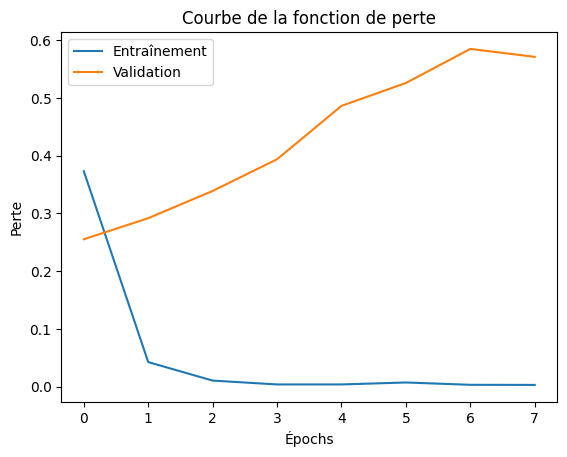

In [71]:
# Tracer la courbe de la fonction de perte
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de la fonction de perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

1041/1041 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


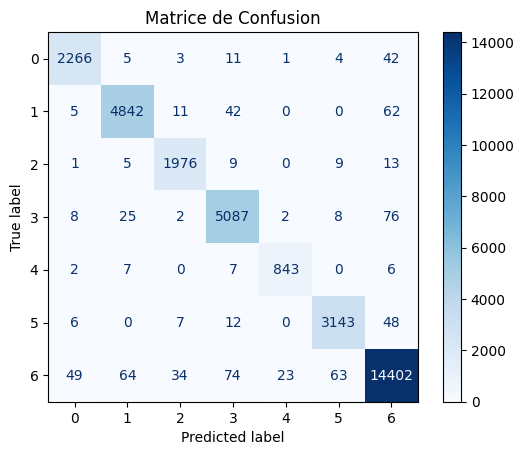

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_train)
y_pred_clusters = np.argmax(y_pred, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_train, y_pred_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

# Afficher la matrice de confusion
plt.title('Matrice de Confusion')
plt.show()

In [73]:
# Obtenir les réponses recommandées
recommended_responses = recommend_responses(user_question, model, data, tfidf_vectorizer)

# Afficher les réponses recommandées sous forme de liste
print("Recommended responses:")
for i, response in enumerate(recommended_responses, start=1):
    print(f"{i}. {response}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Recommended responses:
1. I have tried a bunch of approach 1 Using gradientvector product beginalign vx varepsilon ampapprox vx leftfracpartialpartial x vxrightvarepsilon frac12leftfracpartialpartial xleftfracpartialpartial x vxrightvarepsilonrightvarepsilon frac16leftfracpartialpartial xleftfracpartialpartial x leftfracpartialpartial x vxrightvarepsilonrightvarepsilonrightvarepsilon dot endalign 2 Using the vec function which take a matrix mathbb Rntimes m to mathbb Rnm beginalign vx varepsilon ampapprox vx leftfracpartialpartial x vxrightvarepsilon frac12 varepsilonT leftfracpartial2 vxpartial x2 rightvarepsilon frac16 varepsilon otimes varepsilonT leftfracpartialpartial xmathrmvecleftfracpartial2 vxpartial x2rightrightvarepsilon dot endalign 3 Using index beginalign vx varepsilon ampapprox vx sum_j fracpartial vxpartial x_j varepsilon_j frac12 sum_jk fracpartial vxpartial x_jpartial x_k varepsilon_j varepsilon_k frac16 sum_jkell fracpartial vxpa

In [75]:
recommended_responses = pd.DataFrame(recommended_responses)
data.to_csv('data.csv', index=False)

recommended_responses.to_csv('recommendations.csv', index=False)